In [140]:
import pennylane as qml
import numpy as np
from math import pi
from pennylane.transforms import compile
import matplotlib.pyplot as plt
import pandas as pd

In [120]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate

In [21]:
# Create a bloated circuit with 4 qubits
qc = QuantumCircuit(4)

# Redundant gates and inefficient layout
qc.h(0)
qc.h(0)  # Cancels out with previous H
qc.cx(0, 1)
qc.cx(1, 0)  # Reversible CX pair
qc.swap(0, 2)
qc.swap(2, 0)  # Double swap = identity
qc.rx(0.5, 3)
qc.rx(-0.5, 3)  # Cancels out
qc.rz(0.25, 1)
qc.rz(0.25, 1)  # Can be merged
qc.cx(2, 3)
qc.cx(3, 2)  # Reversible again
qc.measure_all()

In [32]:
qc.draw()

┌───┐      ┌───┐         ┌───┐                                    ░ »
   q_0: ───┤ H ├──────┤ H ├──────■──┤ X ├─X──────────────X───────────────────░─»
           └───┘      └───┘    ┌─┴─┐└─┬─┘ │ ┌──────────┐ │ ┌──────────┐      ░ »
   q_1: ───────────────────────┤ X ├──■───┼─┤ Rz(0.25) ├─┼─┤ Rz(0.25) ├──────░─»
                               └───┘      │ └──────────┘ │ └──────────┘┌───┐ ░ »
   q_2: ──────────────────────────────────X──────────────X──────■──────┤ X ├─░─»
        ┌─────────┐┌──────────┐                               ┌─┴─┐    └─┬─┘ ░ »
   q_3: ┤ Rx(0.5) ├┤ Rx(-0.5) ├───────────────────────────────┤ X ├──────■───░─»
        └─────────┘└──────────┘                               └───┘          ░ »
meas: 4/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌─┐         
«   q_0: ┤M├─────────
«        └╥┘┌─┐      
«   q_1: ─╫─┤M├──────
«         ║ └╥┘┌─┐   
«   q_2: ─╫──╫─┤M├───
«         ║  ║ └╥┘┌─┐
«   q_3: ─╫──╫──╫─┤M├
«         ║  ║  ║ └╥┘
«meas: 4/═╩══╩══╩══╩═
«         0  1  2  3

In [37]:
def summary_qiskit(qc):
    counts = {"1-qubit": 0, "2-qubit": 0}
    for inst in qc.data:
        if isinstance(inst.operation, Gate):  # Skip measurements and non-gates
            num_qubits = len(inst.qubits)
            if num_qubits == 1:
                counts["1-qubit"] += 1
            elif num_qubits == 2:
                counts["2-qubit"] += 1
    return [qc.num_qubits, qc.size(), counts['1-qubit'], counts['2-qubit'], qc.depth()]

In [28]:
summary_qiskit(qc)

[4, 16, 6, 6, 9]

In [90]:
# Transpile with qiskit
backend = Aer.get_backend('qasm_simulator')
transpiled_qiskit_2 = transpile(qc, backend) # level 2
summary_qiskit(transpiled_qiskit_2)

[4, 11, 1, 6, 7]

In [35]:
transpiled_qiskit_2.draw()

global phase: 6.0332
             ┌───┐                            ░ ┌─┐         
   q_0: ──■──┤ X ├────────────X──X────────────░─┤M├─────────
        ┌─┴─┐└─┬─┘┌─────────┐ │  │            ░ └╥┘┌─┐      
   q_1: ┤ X ├──■──┤ U1(0.5) ├─┼──┼────────────░──╫─┤M├──────
        └───┘     └─────────┘ │  │      ┌───┐ ░  ║ └╥┘┌─┐   
   q_2: ──────────────────────X──X───■──┤ X ├─░──╫──╫─┤M├───
                                   ┌─┴─┐└─┬─┘ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────────────────┤ X ├──■───░──╫──╫──╫─┤M├
                                   └───┘      ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                 0  1  2  3

In [91]:
transpiled_qiskit_3 = transpile(qc, backend, optimization_level=3) # level 3
print(summary_qiskit(transpiled_qiskit_3))
transpiled_qiskit_3.draw()

[4, 9, 1, 4, 4]


┌───┐            ░ ┌─┐         
Qubit(QuantumRegister(4, 'q'), 0) -> 0 ──■──┤ X ├────────────░─┤M├─────────
                                       ┌─┴─┐└─┬─┘┌─────────┐ ░ └╥┘┌─┐      
Qubit(QuantumRegister(4, 'q'), 1) -> 1 ┤ X ├──■──┤ Rz(0.5) ├─░──╫─┤M├──────
                                       └───┘┌───┐└─────────┘ ░  ║ └╥┘┌─┐   
Qubit(QuantumRegister(4, 'q'), 2) -> 2 ──■──┤ X ├────────────░──╫──╫─┤M├───
                                       ┌─┴─┐└─┬─┘            ░  ║  ║ └╥┘┌─┐
Qubit(QuantumRegister(4, 'q'), 3) -> 3 ┤ X ├──■──────────────░──╫──╫──╫─┤M├
                                       └───┘                 ░  ║  ║  ║ └╥┘
                               meas: 4/═════════════════════════╩══╩══╩══╩═
                                                                0  1  2  3

Matplotlib is building the font cache; this may take a moment.


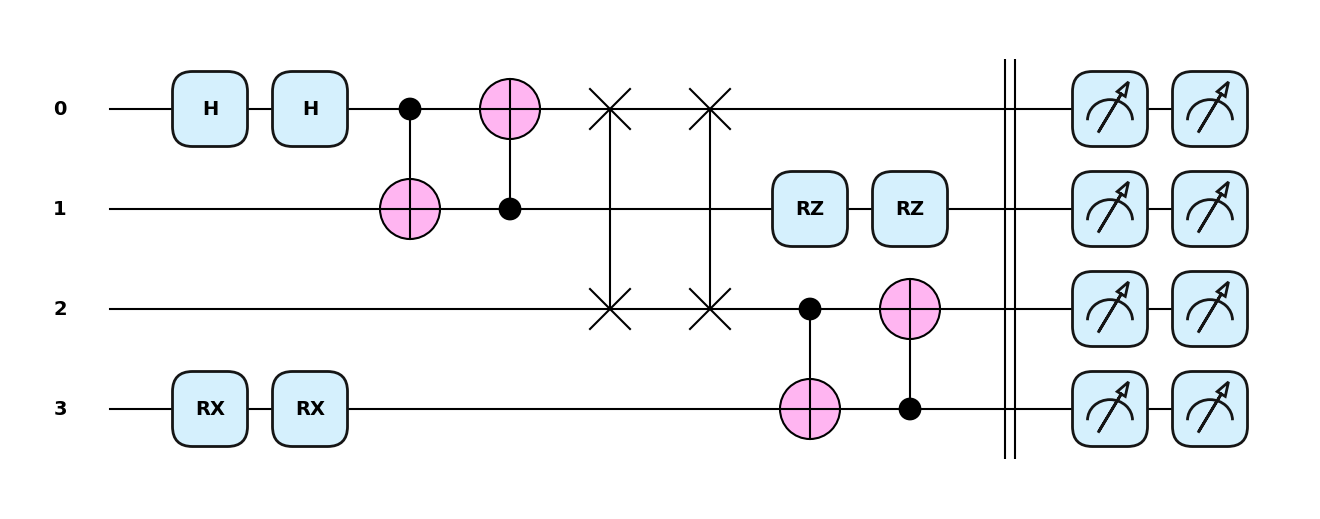

In [88]:
pc_penny = qml.from_qiskit(qc)
num_q = qc.num_qubits
dev = qml.device("default.qubit", wires=num_q)

@qml.qnode(dev)
def circuit():
    pc_penny(wires=range(num_q))
    return qml.state()

qml.draw_mpl(circuit, style='pennylane')()
plt.show()

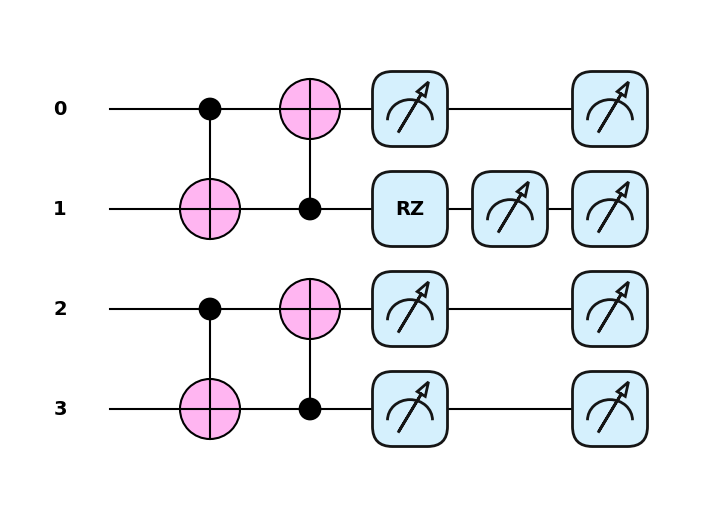

In [75]:
transpiled_penny = compile(circuit)
qml.draw_mpl(transpiled_penny, style='pennylane')()
plt.show()

In [78]:
def summary_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    return [obj.num_wires, obj.num_gates, obj.gate_sizes[1], obj.gate_sizes[2], obj.depth]

summary_penny(circuit)

[4, 17, 10, 6, 10]

In [79]:
summary_penny(transpiled_penny)

[4, 9, 5, 4, 4]

In [93]:
df = pd.DataFrame(columns=['original','qiskit_2','qiskit_3','penny'])
df['original'] = summary_qiskit(qc)
df['qiskit_2'] = summary_qiskit(transpiled_qiskit_2)
df['qiskit_3'] = summary_qiskit(transpiled_qiskit_3)
df['penny'] = summary_penny(transpiled_penny)
df.index = ['qubits', 'gates', '1q gates', '2q gates', 'depth']
df

,original,qiskit_2,qiskit_3,penny
qubits,4,4,4,4
gates,16,11,9,9
1q gates,6,1,1,5
2q gates,6,6,4,4
depth,9,7,4,4


In [94]:
def make_table(qc):
    df = pd.DataFrame(columns=['original','qiskit_2','qiskit_3','penny'])
    df['original'] = summary_qiskit(qc)
    df['qiskit_2'] = summary_qiskit(transpiled_qiskit_2)
    df['qiskit_3'] = summary_qiskit(transpiled_qiskit_3)
    df['penny'] = summary_penny(transpiled_penny)
    df.index = ['qubits', 'gates', '1q gates', '2q gates', 'depth']
    print(df)

In [95]:
make_table(qc)

          original  qiskit_2  qiskit_3  penny
qubits           4         4         4      4
gates           16        11         9      9
1q gates         6         1         1      5
2q gates         6         6         4      4
depth            9         7         4      4


In [98]:
# test with a sample form ketgpt
# Mapping from PennyLane to Qiskit
[ds] = qml.data.load("ketgpt")
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 999
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

In [115]:
sample_q_num = qml.specs(circuit)()['resources'].num_wires

In [99]:
gate_name = []
gate_info = []
for op in ds.circuits[0]:
    name = op.name
    gate_name.append(name)
    wires = [int(w) for w in op.wires]
    params = op.parameters
    gate_info.append({
        "name": name,
        "wires": wires,
        "params": params,
    })
gate_info[:3]

[{'name': 'Hadamard', 'wires': [0], 'params': []},
 {'name': 'Hadamard', 'wires': [1], 'params': []},
 {'name': 'Hadamard', 'wires': [2], 'params': []}]

In [141]:
def to_qiskit(dict_elem):
    name = dict_elem['name']
    wire = dict_elem['wires']
    param = dict_elem['params']
    if name == 'Hadamard':
        qc.h(wire[0])
    if name == 'PauliX':
        qc.x(wire[0])
    if name == 'CNOT':
        qc.cx(wire[0],wire[1])
    if name == 'CZ':
        qc.cz(wire[0],wire[1])    
    if name == 'QubitUnitary':
        qc.append(UnitaryGate(param[0]),wire)
    if name == 'U2':
        qc.u(pi/2, param[0], param[1], wire[0])

In [142]:
gate_info[0]['name']

'Hadamard'

In [143]:
# Create a bloated circuit with 4 qubits
qc = QuantumCircuit(sample_q_num)
for dict_elem in gate_info:
    to_qiskit(dict_elem)
qc.measure_all()

In [144]:
make_table(qc)

          original  qiskit_2  qiskit_3  penny
qubits          13         4         4      4
gates          218        11         9      9
1q gates       116         1         1      5
2q gates        89         6         4      4
depth           73         7         4      4
